# FAOSTAT Case 5

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split

Load all the necessary libraries and functions.

In [2]:
# Load file path
file_path = r"C:\\Users\\tssp4001\Desktop\\spartak\\fao_case\\fao_data_vietnam_nigeria.xlsx"

# Load all sheet names
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

for i, name in enumerate(xls.sheet_names):
    print(f"Sheet {i}: {name}")


Sheet 0: final_1y_Germany
Sheet 1: final_3y_Germany
Sheet 2: final Germany
Sheet 3: Germany 1yr merged
Sheet 4: Sheet3
Sheet 5: FBS Germany
Sheet 6: FBSH Germany
Sheet 7: FS Germany
Sheet 8: final_1y_vietnam
Sheet 9: final_3y_vietnam
Sheet 10: final_1y_nigeria
Sheet 11: final_3y_nigeria


In [3]:
fs_3year = pd.read_excel(file_path, sheet_name=11)
fbs = pd.read_excel(file_path, sheet_name=10)

### Make a 3-year rolling mean for the FS dataset where there are values on 1 and 3 year basis

In [ ]:
# Make sure column is string
#fs["Year"] = fs["Year"].astype(str)
#
# Convert the target columns to numeric
#cols_to_avg = [
#    "Average dietary energy requirement (kcal/cap/day)",
#    "Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day)",
#    "Minimum dietary energy requirement  (kcal/cap/day)",
#    "Number of obese adults (18 years and older) (million)",
#     "Prevalence of obesity in the adult population (18 years and older) (percent)"
#]
#for col in cols_to_avg:
#    fs[col] = pd.to_numeric(fs[col], errors='coerce')
#
# Separate 1-year rows from 3-year period rows
#fs_1year = fs[~fs["Year"].str.contains("-")].copy()
#fs_3year = fs[fs["Year"].str.contains("-")].copy()
#
# Convert 1-year 'Year' column to int for comparison
#fs_1year["Year"] = fs_1year["Year"].astype(int)
#
# Compute 3-year averages
#for idx, row in fs_3year.iterrows():
#    try:
#        start_year, end_year = map(int, row["Year"].split("-"))
#        # Get the relevant rows from 1-year data
#        mask = fs_1year["Year"].between(start_year, end_year)
#        avg_values = fs_1year.loc[mask, cols_to_avg].mean()
#        fs_3year.loc[idx, cols_to_avg] = avg_values.values
#    except Exception as e:
#        print(f"Error at row {idx} ({row['Year']}): {e}")
#
# Reset index
#fs_3year = fs_3year.reset_index(drop=True)
#
# Preview result
#print(fs_3year[["Year"] + cols_to_avg].head())

Empty DataFrame
Columns: [Year, Average dietary energy requirement (kcal/cap/day), Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day), Minimum dietary energy requirement  (kcal/cap/day), Number of obese adults (18 years and older) (million), Prevalence of obesity in the adult population (18 years and older) (percent)]
Index: []


## Start modelling

### Make both datasets stationary

In [4]:
df = fbs.copy()
cols_to_check = df.columns[6:]  # columns to check for stationarity

# Function to run ADF test and return p-value
def adf_pvalue(series):
    series = series.dropna()
    if len(series) < 3:
        return None
    return adfuller(series)[1]

# Start with a copy of df
fbs_stationary = df.copy()

# Process each column
for col in cols_to_check:
    print(f"\nColumn: {col}")
    series = df[col]

    # Check original
    pval = adf_pvalue(series)
    print(f"  Original p-value: {pval}")
    if pval is not None and pval < 0.05:
        print("  -> Stationary (original)")
        continue  # keep original in fbs_stationary

    # First difference
    first_diff = series.diff()
    pval1 = adf_pvalue(first_diff)
    print(f"  First diff p-value: {pval1}")
    if pval1 is not None and pval1 < 0.05:
        print("  -> Stationary after first difference")
        fbs_stationary[col] = first_diff
        continue

    # Second difference
    second_diff = first_diff.diff()
    pval2 = adf_pvalue(second_diff)
    print(f"  Second diff p-value: {pval2}")
    if pval2 is not None and pval2 < 0.05:
        print("  -> Stationary after second difference")
        fbs_stationary[col] = second_diff
        continue

    # Third difference
    third_diff = second_diff.diff()
    pval3 = adf_pvalue(third_diff)
    print(f"  Third diff p-value: {pval3}")
    if pval3 is not None and pval3 < 0.05:
        print("  -> Stationary after third difference")
        fbs_stationary[col] = third_diff
    else:
        print("  -> Still non-stationary after third difference")
        fbs_stationary[col] = third_diff  # or keep as NaN if you prefer



Column: Total Losses (1000 t)
  Original p-value: 0.6577080013061012
  First diff p-value: 0.9762904975867185
  Second diff p-value: 0.2265111099105035
  Third diff p-value: 0.002244773583718788
  -> Stationary after third difference

Column: Fat supply quantity (g/capita/day)_Animal Products
  Original p-value: 0.8263008734120825
  First diff p-value: 0.9419588108201078
  Second diff p-value: 0.007658302985389287
  -> Stationary after second difference

Column: Fat supply quantity (g/capita/day)_Grand Total
  Original p-value: 0.07163705878369803
  First diff p-value: 0.04793748354471599
  -> Stationary after first difference

Column: Fat supply quantity (g/capita/day)_Vegetal Products
  Original p-value: 0.09699342731217359
  First diff p-value: 0.05272764164938979
  Second diff p-value: 0.04559517725175066
  -> Stationary after second difference

Column: Food supply (kcal/capita/day)_Animal Products
  Original p-value: 1.0
  First diff p-value: 0.7477051926724637
  Second diff p-va

In [ ]:
#fs_3year['Prevalence of undernourishment (percent) (3-year average)'] = fs_3year['Prevalence of undernourishment (percent) (3-year average)'].str.replace('<', '', regex=False)
#fs_3year['Prevalence of undernourishment (percent) (3-year average)'] = pd.to_numeric(fs_3year['Prevalence of undernourishment (percent) (3-year average)'], errors='coerce')

In [5]:
df = fs_3year.copy()
cols_to_check = df.columns[6:20]  # columns to check for stationarity

# Function to run ADF test and return p-value
def adf_pvalue(series):
    series = series.dropna()
    if len(series) < 3:
        return None
    return adfuller(series)[1]

# Create new DataFrame to store stationary versions
fs_3year_stationary = df.copy()

# Loop through columns and apply differencing as needed
for col in cols_to_check:
    print(f"\nColumn: {col}")
    series = df[col]

    # Check original
    pval = adf_pvalue(series)
    print(f"  Original p-value: {pval}")
    if pval is not None and pval < 0.05:
        print("  -> Stationary (original)")
        continue  # keep original

    # First difference
    first_diff = series.diff()
    pval1 = adf_pvalue(first_diff)
    print(f"  First diff p-value: {pval1}")
    if pval1 is not None and pval1 < 0.05:
        print("  -> Stationary after first difference")
        fs_3year_stationary[col] = first_diff
        continue

    # Second difference
    second_diff = first_diff.diff()
    pval2 = adf_pvalue(second_diff)
    print(f"  Second diff p-value: {pval2}")
    if pval2 is not None and pval2 < 0.05:
        print("  -> Stationary after second difference")
        fs_3year_stationary[col] = second_diff
        continue

    # Third difference
    third_diff = second_diff.diff()
    pval3 = adf_pvalue(third_diff)
    print(f"  Third diff p-value: {pval3}")
    if pval3 is not None and pval3 < 0.05:
        print("  -> Stationary after third difference")
        fs_3year_stationary[col] = third_diff
    else:
        print("  -> Still non-stationary after third difference")
        fs_3year_stationary[col] = third_diff  # optional fallback



Column: Total Losses (1000 t)
  Original p-value: 0.998152147310546
  First diff p-value: 0.9694825829451648
  Second diff p-value: 8.874790646675426e-06
  -> Stationary after second difference

Column: Fat supply quantity (g/capita/day)_Animal Products
  Original p-value: 0.8939728138405051
  First diff p-value: 0.000350696364328645
  -> Stationary after first difference

Column: Fat supply quantity (g/capita/day)_Grand Total
  Original p-value: 3.684344942875597e-18
  -> Stationary (original)

Column: Fat supply quantity (g/capita/day)_Vegetal Products
  Original p-value: 0.0822885505377815
  First diff p-value: 3.3070814683614264e-05
  -> Stationary after first difference

Column: Food supply (kcal/capita/day)_Animal Products
  Original p-value: 0.08133701018552897
  First diff p-value: 0.05835968460595609
  Second diff p-value: 0.9466557347682286
  Third diff p-value: 0.6136241258688698
  -> Still non-stationary after third difference

Column: Food supply (kcal/capita/day)_Grand T

All desired values are being converted to stationary above. This is a needed measure because we aim for constant mean and variance which is crucial for time series. We hope this has postive impact over the calculations of OLS regression and Lasso. Later, we will observe whether the dependent variables are significant for predicting obesity in the society. By doing that, we strive to avoid biased coefficients. 

We can see that some variables are already stationary at the beginning. However, some would need to be transformed with their first/second/third difference to become stationary. Then, the new values are obtained.

In [5]:
# Save both as csv for checks 
fbs_stationary.to_csv('fbs_stationary_vietnam_last.csv', index=False)
fs_3year_stationary.to_csv('fs_3year_stationary_vietnam_last.csv', index=False)

### Drop some columns (Food Losses (1000t), Population)

In [6]:
fbs_stationary = fbs_stationary.drop(columns=["Total Losses (1000 t)", "Population (1000no)"])

The population and total food losses in 1000t wouldn't be useful for us so we decide to remove those columns before we start with our modelling.

### Check correlations and drop correlated factors with above 80% (but without food losses)

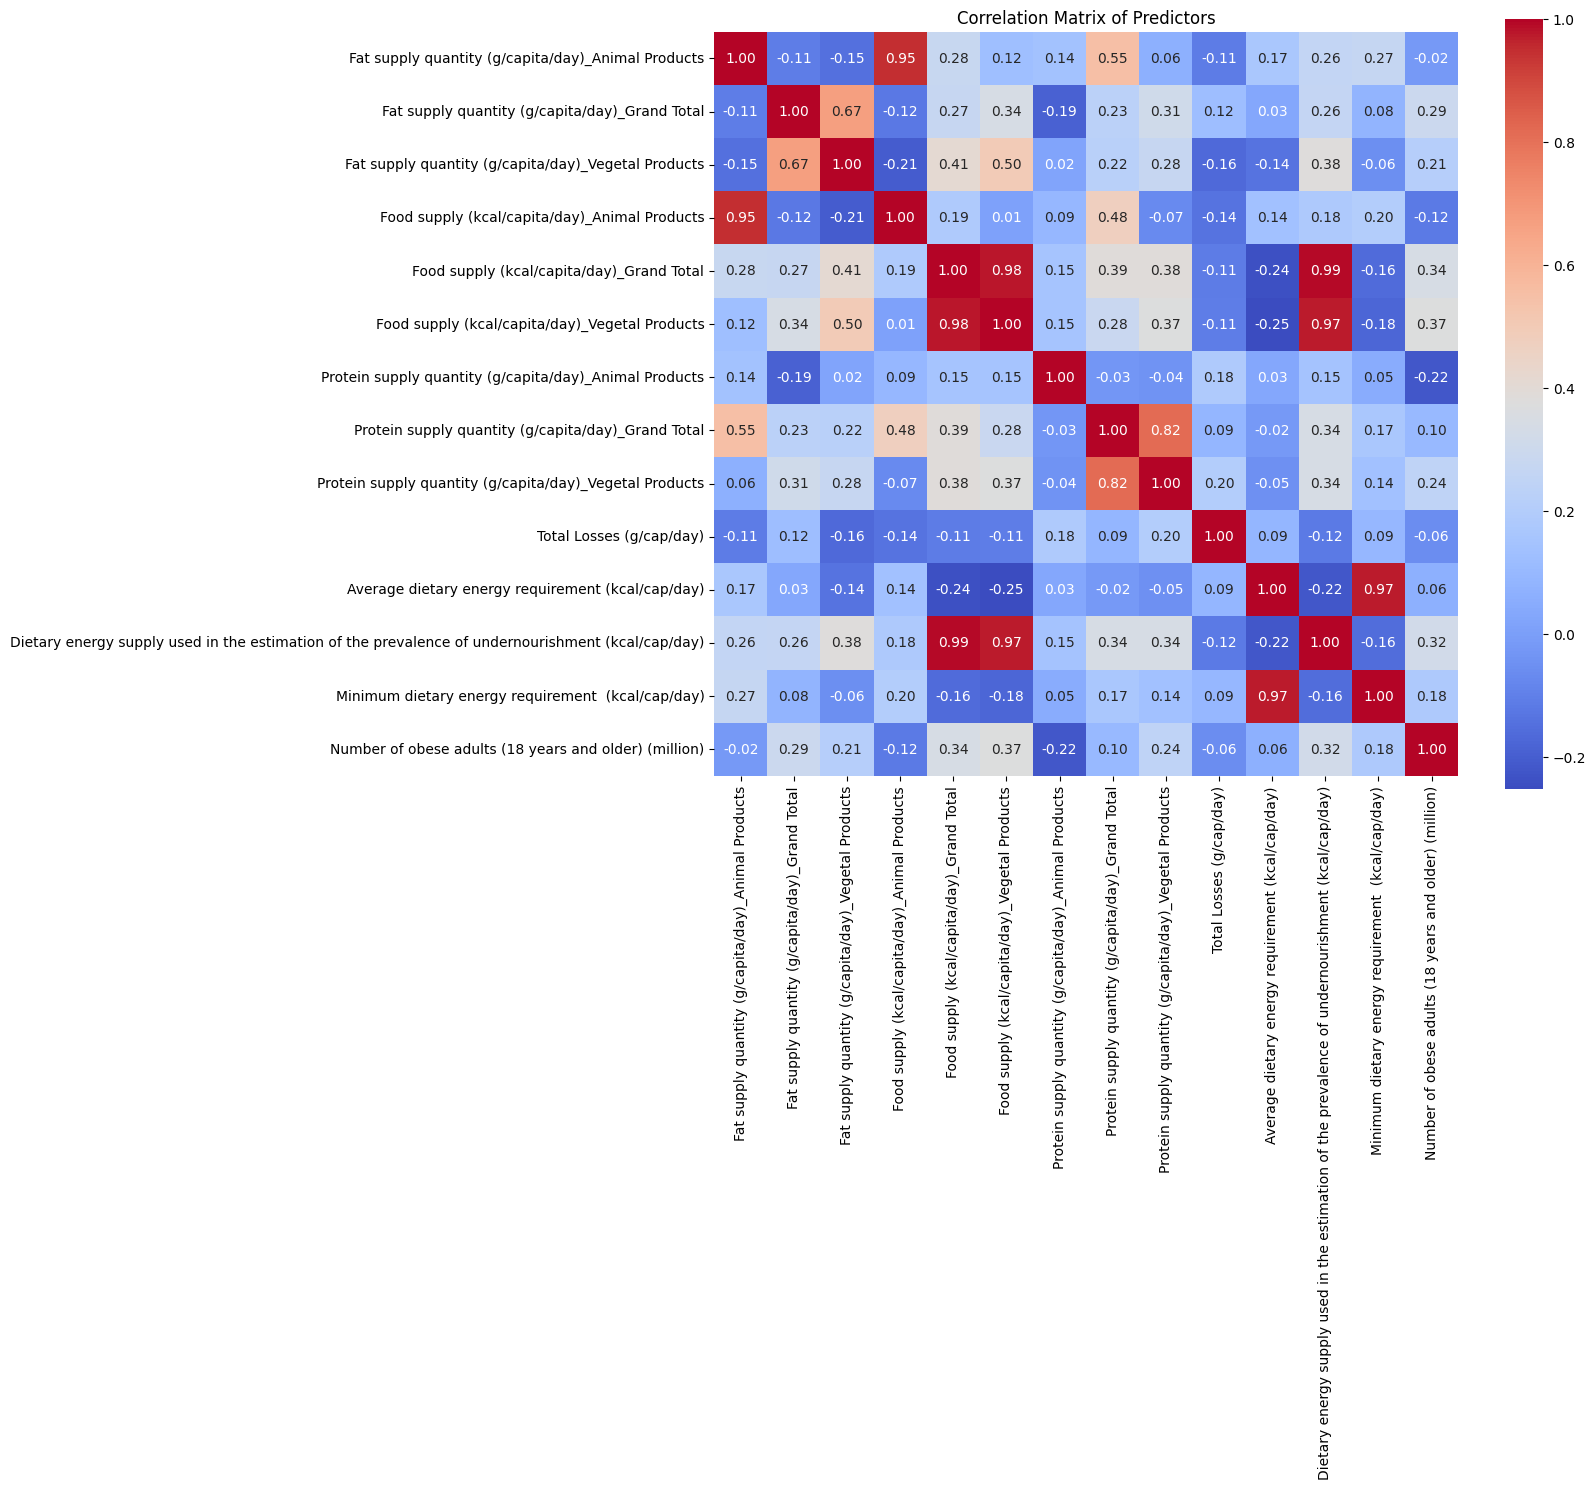

In [7]:
# Drop metadata and target
cols_to_exclude = ['Domain Code', 'Domain', 'Area Code', 'Area', 'Year Code', 'Year', 'Prevalence of obesity in the adult population (18 years and older) (percent)']
X = fbs_stationary.drop(columns=cols_to_exclude, errors='ignore').select_dtypes(include='number')

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Predictors")
plt.show()

After checking the correlation between the independent variables, we observe we have big positive relationships. This seems logical because the columns we have are conveying similar meaning. That's the reason why we remove the redundant ones because multicolinearity might be problematic for our results.

In [8]:
protected_column = "Prevalence of obesity in the adult population (18 years and older) (percent)"

# Compute correlation matrix
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns to drop, skipping the protected one
to_drop = []
for column in upper.columns:
    if column == protected_column:
        continue  # Skip dropping this one
    if any(upper[column] > 0.8):
        to_drop.append(column)

print("❌ Dropping due to high correlation (except protected):")
print(to_drop)

# Drop selected columns
X_uncorrelated = X.drop(columns=to_drop)

❌ Dropping due to high correlation (except protected):
['Food supply (kcal/capita/day)_Animal Products', 'Food supply (kcal/capita/day)_Vegetal Products', 'Protein supply quantity (g/capita/day)_Vegetal Products', 'Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day)', 'Minimum dietary energy requirement  (kcal/cap/day)']


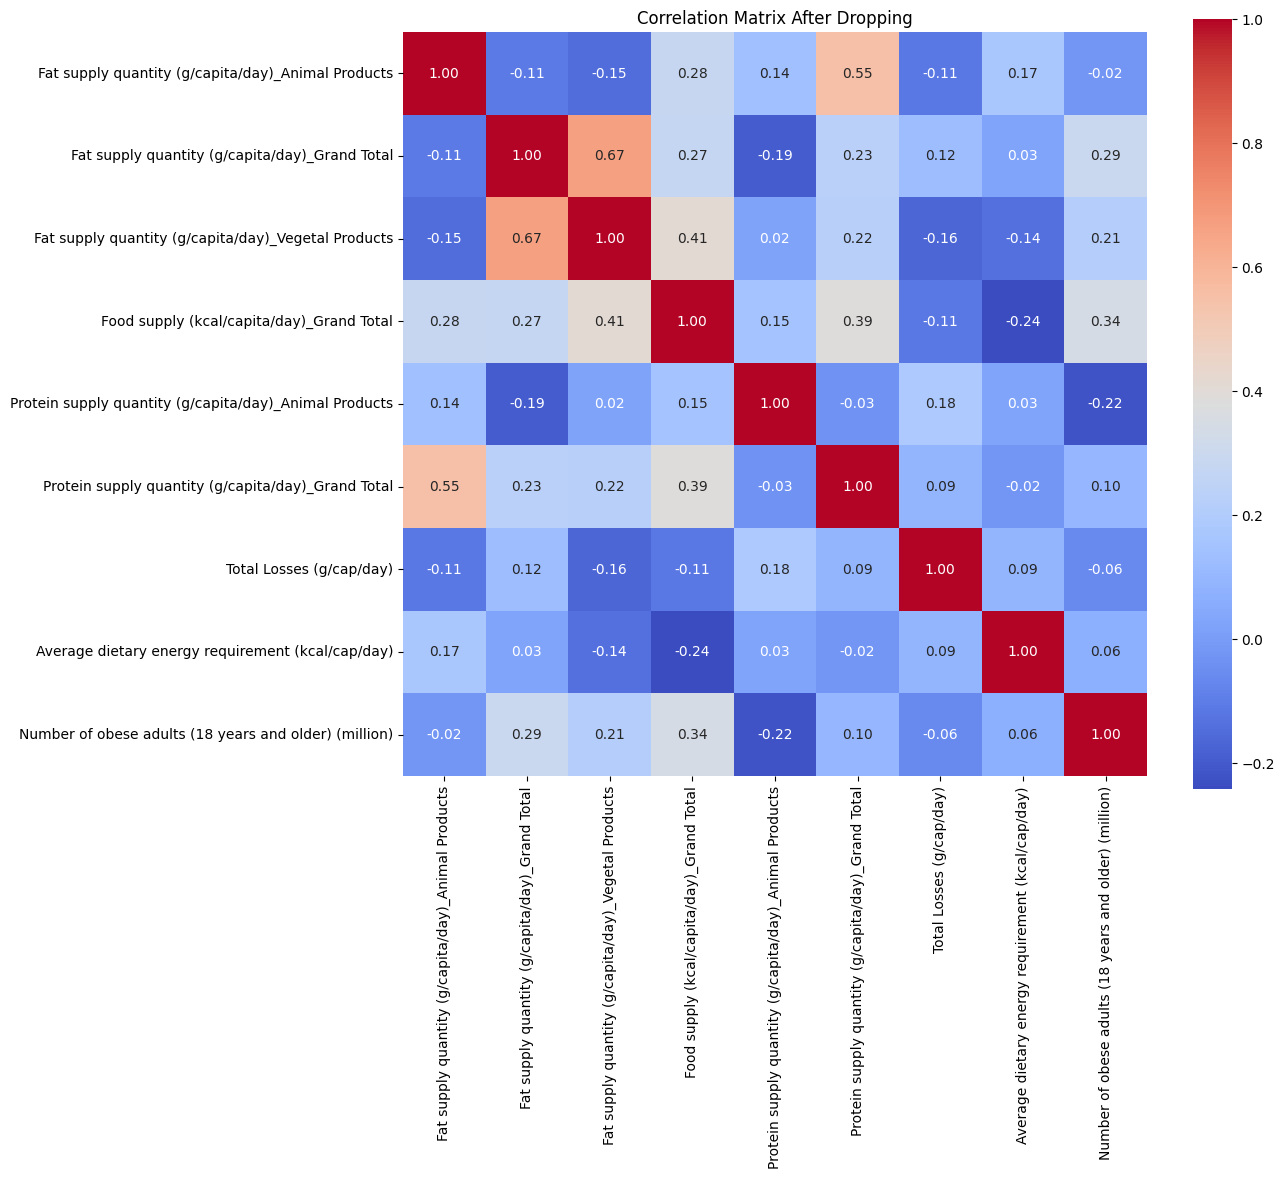

In [9]:
# Plot new heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X_uncorrelated.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix After Dropping")
plt.show()

### Now run OLS regression to check coefficients 

In [10]:
# Your target variable
y = fbs_stationary['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Drop rows with any missing values in predictors or target
data = pd.concat([X_uncorrelated, y], axis=1).dropna()

# Define cleaned X and y
X_clean = data.drop(columns=['Prevalence of obesity in the adult population (18 years and older) (percent)']).astype(float)
y_clean = data['Prevalence of obesity in the adult population (18 years and older) (percent)'].astype(float)

# Add constant for intercept
X_const = sm.add_constant(X_clean)

# Fit the OLS model
ols_model = sm.OLS(y_clean, X_const).fit()

# Show regression summary
print(ols_model.summary())

# Check multicollinearity via VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print("\n📊 Variance Inflation Factors (VIF):")
print(vif_data)

                                                         OLS Regression Results                                                         
Dep. Variable:     Prevalence of obesity in the adult population (18 years and older) (percent)   R-squared:                       0.657
Model:                                                                                      OLS   Adj. R-squared:                  0.348
Method:                                                                           Least Squares   F-statistic:                     2.127
Date:                                                                          Sun, 29 Jun 2025   Prob (F-statistic):              0.128
Time:                                                                                  10:05:07   Log-Likelihood:                 34.348
No. Observations:                                                                            20   AIC:                            -48.70
Df Residuals:                            

When we run linear regression with OLS, we can see that all the values except two are not statistically significant therefore there is no direct linear connection between them and obesity. Only Fat supply quantity (g/capita/day)Animal Products and can be interpreted to have direct influence on obesity.  F-statistic p-value = 0.128 means that the model is overall not statistically significant. The model explains about 66.7% of the variance in adult obesity prevalence, which is not the best possible outcome.

### Now run Lasso to check weights when predicting food losses

In [11]:
# Drop first 6 columns + target column from predictors
excluded_cols = fbs_stationary.columns[:6].tolist() + [
    'Prevalence of obesity in the adult population (18 years and older) (percent)',
    'Number of obese adults (18 years and older) (million)'
]
X_lasso = fbs_stationary.drop(columns=excluded_cols)

# Drop rows with missing values
df_lasso = pd.concat([X_lasso, fbs_stationary['Prevalence of obesity in the adult population (18 years and older) (percent)']], axis=1).dropna()
X_lasso_clean = df_lasso.drop(columns=['Prevalence of obesity in the adult population (18 years and older) (percent)'])
y_lasso = df_lasso['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Create and fit the Lasso pipeline
lasso_pipeline = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, random_state=42)
)
lasso_pipeline.fit(X_lasso_clean, y_lasso)

# Extract the trained LassoCV model
lasso_model = lasso_pipeline.named_steps['lassocv']

# Show selected alpha
print(f"🔧 Best alpha: {lasso_model.alpha_:.5f}")

# Get coefficients
lasso_coef = pd.Series(lasso_model.coef_, index=X_lasso_clean.columns)
selected_features = lasso_coef[lasso_coef != 0].sort_values(ascending=False)

# Print results
print("\n✅ Selected Features (non-zero coefficients):")
print(selected_features)

print("\n❌ Dropped Features (coefficients = 0):")
print(lasso_coef[lasso_coef == 0].index.tolist())

🔧 Best alpha: 0.00894

✅ Selected Features (non-zero coefficients):
Total Losses (g/cap/day)                                  0.015603
Protein supply quantity (g/capita/day)_Animal Products   -0.047042
dtype: float64

❌ Dropped Features (coefficients = 0):
['Fat supply quantity (g/capita/day)_Animal Products', 'Fat supply quantity (g/capita/day)_Grand Total', 'Fat supply quantity (g/capita/day)_Vegetal Products', 'Food supply (kcal/capita/day)_Animal Products', 'Food supply (kcal/capita/day)_Grand Total', 'Food supply (kcal/capita/day)_Vegetal Products', 'Protein supply quantity (g/capita/day)_Grand Total', 'Protein supply quantity (g/capita/day)_Vegetal Products', 'Average dietary energy requirement (kcal/cap/day)', 'Dietary energy supply used in the estimation of the prevalence of undernourishment (kcal/cap/day)', 'Minimum dietary energy requirement  (kcal/cap/day)']


C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.749e-05, tolerance: 9.938e-06
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-04, tolerance: 9.938e-06
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feat

Lasso regression points out that there are only 2 predictors which are valuable, all others are penalized and left out as zeros. The model wouldn't overfit with this value of alpha, but it has a few useful features.

C:\Users\tssp4001\AppData\Local\Temp\ipykernel_60976\1419078544.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\tssp4001\AppData\Local\Temp\ipykernel_60976\1419078544.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


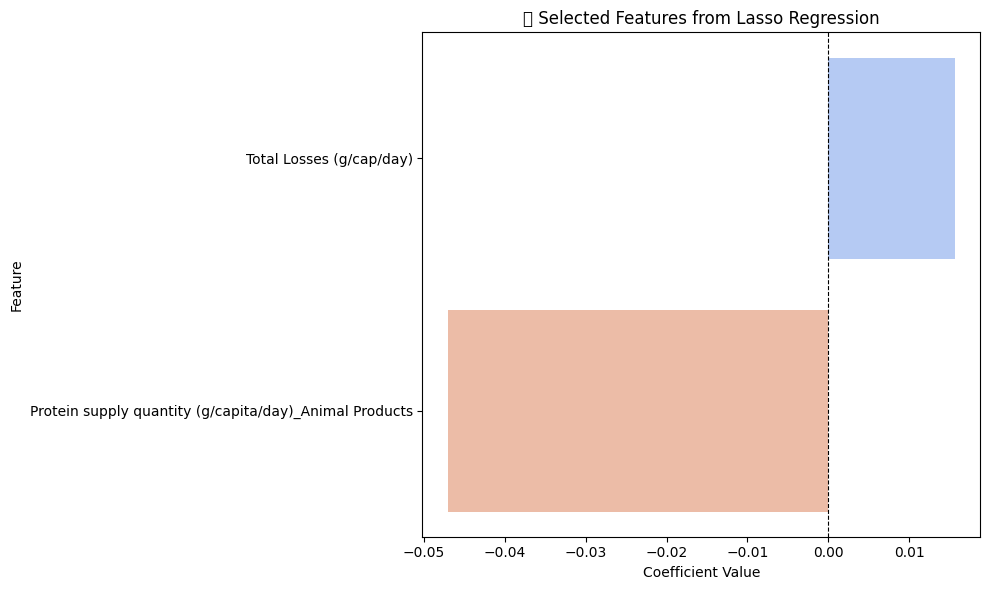

In [13]:
# Prepare data
selected_features_sorted = selected_features.sort_values(key=abs, ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=selected_features_sorted.values,
    y=selected_features_sorted.index,
    palette='coolwarm',
    orient='h'
)
plt.title('🔍 Selected Features from Lasso Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()

### Now run Random Forest to obtain predictors related to food losses

C:\Users\tssp4001\AppData\Local\Temp\ipykernel_60976\3756936689.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_sorted, y=importances_sorted.index, palette="viridis")
C:\Users\tssp4001\AppData\Local\Temp\ipykernel_60976\3756936689.py:23: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


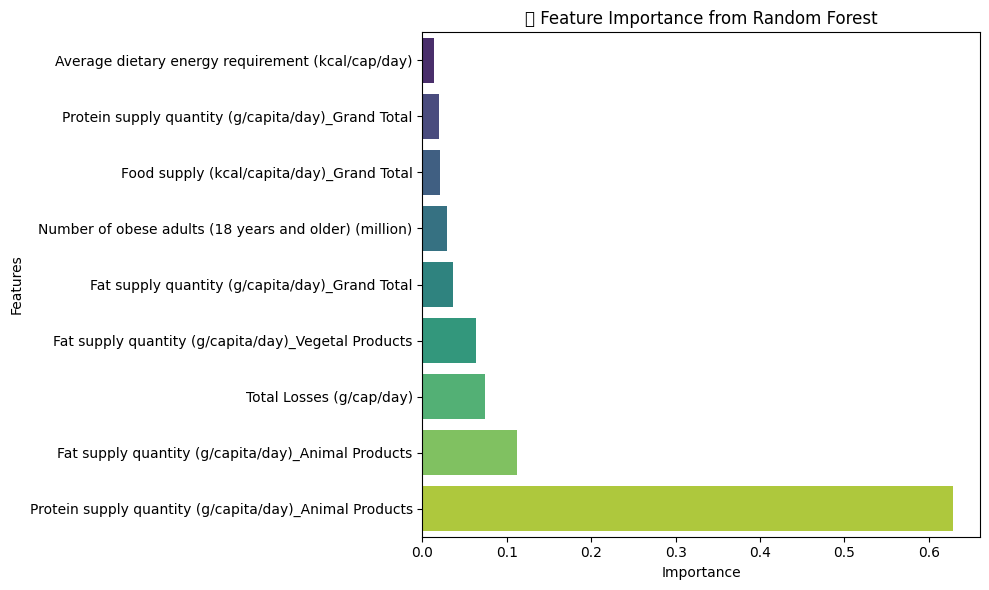

In [14]:
# Target variable
y_rf = fbs_stationary['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Drop rows with missing values (only where needed)
df_rf = pd.concat([X_uncorrelated, y_rf], axis=1).dropna()
X_rf_clean = df_rf.drop(columns=['Prevalence of obesity in the adult population (18 years and older) (percent)'])
y_rf_clean = df_rf['Prevalence of obesity in the adult population (18 years and older) (percent)']

# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf_clean, y_rf_clean)

# Feature importances
importances = pd.Series(rf_model.feature_importances_, index=X_rf_clean.columns)
importances_sorted = importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted, y=importances_sorted.index, palette="viridis")
plt.title("🌲 Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

C:\Users\tssp4001\AppData\Local\Temp\ipykernel_60976\981965292.py:14: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\tssp4001\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


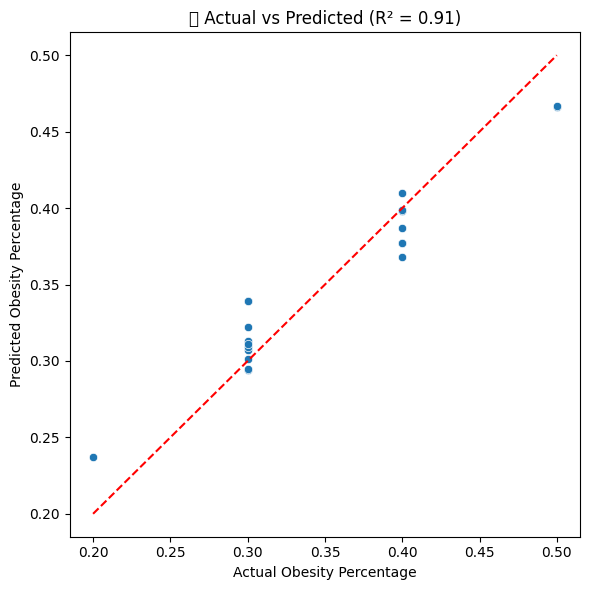

In [15]:
# Predictions
y_pred = rf_model.predict(X_rf_clean)

# R² score
r2 = r2_score(y_rf_clean, y_pred)

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_rf_clean, y=y_pred)
plt.plot([y_rf_clean.min(), y_rf_clean.max()], [y_rf_clean.min(), y_rf_clean.max()], 'r--')
plt.xlabel("Actual Obesity Percentage")
plt.ylabel("Predicted Obesity Percentage")
plt.title(f"🎯 Actual vs Predicted (R² = {r2:.2f})")
plt.tight_layout()
plt.show()

Protein supply quantity (g/capita/day) Animal Products once again has the highest predictive power with 0.62. The other coefficients are much less which means the animal products and their protein supply shape the obesity. The R^2 here explaining variance is 0.91 which is quite a good result compared to the other regressions above.